## Project: Anamoly Detection

### Import Libraries

In [1]:
#Import libraries
import cv2     # for capturing videos
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
import zipfile
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Conv2D,MaxPooling2D, Dropout
from keras.layers.core import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.layers import Flatten, TimeDistributed,InputLayer, Reshape
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.engine.input_layer import Input
import matplotlib.image as mpimg
import io
import zipfile

Using TensorFlow backend.


### Export Zip Files

In [5]:
zipfile.ZipFile('A.zip').extractall()

In [6]:
zipfile.ZipFile('B-F.zip').extractall()

In [7]:
zipfile.ZipFile('N-1-154.zip').extractall()

In [8]:
zipfile.ZipFile('N-1-337.zip').extractall()

In [9]:
zipfile.ZipFile('N-1-558.zip').extractall()

In [10]:
#zipfile.ZipFile('N-1-906.zip').extractall()

In [11]:
#zipfile.ZipFile('N-1-922.zip').extractall()

In [12]:
#zipfile.ZipFile('Robbery.zip').extractall()

In [13]:
#zipfile.ZipFile('S-V.zip').extractall()

### Convert videos to numpy array

In [2]:
#Store all files in a directory as list
L=glob.glob("*.mp4")

In [3]:
M=[]
for i in range(0,len(L)):
    if 'Normal' in L[i]:
        M.append(0)
    else:
        M.append(1)

In [4]:
np.unique(M,return_counts=True)

(array([0, 1]), array([232, 144]))

In [5]:
#Convert videos to numpy arrays: dimension: number of videos, number of frames per video, height of a frame, width of a frame
training_data_X=[]
length=[]

for i in range(0,len(L)):
    cap = cv2.VideoCapture(L[i])
    #print(L[i])
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(frameCount)
    cap.release()
    length.append(frameCount)

#max_frame=max(length)
max_frame=300

for i in range(0,len(L)):
    cap = cv2.VideoCapture(L[i])
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #print(frameCount)
    
    if frameCount<max_frame:
        buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
        #print(frameCount)
    
        fc = 0
        ret = True
    
        while (fc < frameCount  and ret):
            ret, buf[fc] = cap.read()
            fc += 1
        cap.release()
    
    else:
        buf = np.empty((max_frame, frameHeight, frameWidth, 3), np.dtype('uint8'))
        #print(frameCount)
    
        fc = 0
        ret = True
    
        for i in range(int(frameCount/2-max_frame/2),(int(frameCount/2-max_frame/2)+max_frame)):
            while (fc < max_frame  and ret):
                cap.set(1, i)
                ret, buf[fc] = cap.read()
                #plt.imshow(buf[fc])
                fc += 1
        cap.release()
    
    if frameCount<max_frame:
        gray = [np.zeros((frameHeight,frameWidth))]*frameCount
        for i in range(0,frameCount):
            gray[i]=cv2.cvtColor(buf[i],cv2.COLOR_RGB2GRAY)
        gray=np.asarray(gray)
    
    else:
        gray = [np.zeros((frameHeight,frameWidth))]*max_frame
        for i in range(0,max_frame):
            gray[i]=cv2.cvtColor(buf[i],cv2.COLOR_RGB2GRAY)
        gray=np.asarray(gray)
    
    width=128
    height=128
    
    if frameCount<max_frame:
        re_size=[np.zeros((height,width))]*frameCount
        for i in range(0,frameCount):
            re_size[i]=cv2.resize(gray[i],(height, width))
        re_size=np.asarray(re_size)
    
    else:
        re_size=[np.zeros((height,width))]*max_frame
        for i in range(0,max_frame):
            re_size[i]=cv2.resize(gray[i],(height, width))
        re_size=np.asarray(re_size)
    
    if frameCount<max_frame:
        normal_size=[np.zeros((height,width))]*frameCount
        for i in range(0,frameCount):
            normal_size[i]=cv2.normalize(re_size[i],None,0,255,cv2.NORM_MINMAX)
        normal_size=np.asarray(normal_size)
        #print(normal_size.shape)
    
    else:
        normal_size=[np.zeros((height,width))]*max_frame
        for i in range(0,max_frame):
            normal_size[i]=cv2.normalize(re_size[i],None,0,255,cv2.NORM_MINMAX)
        normal_size=np.asarray(normal_size)
        #print(normal_size.shape)
    
    #Stacking empty arrays with the existing array so that number of frames per video is same    
    #print(max_frame)
    if frameCount<max_frame:
        empty_array=[np.zeros((height,width))]*(max_frame-frameCount)
        empty_array=np.asarray(empty_array)
        padded_normal=np.vstack((normal_size,empty_array))
    
    else:
        padded_normal=normal_size
    
    #print(padded_normal.shape)
    training_data_X.append(padded_normal)
training_data_X=np.asarray(training_data_X)

In [6]:
training_data_X.shape

(376, 300, 128, 128)

In [7]:
#Reshape data, why is it required?
training_data_X2=training_data_X.reshape(training_data_X.shape[0],
                                         training_data_X.shape[1],
                                         training_data_X.shape[2],
                                         training_data_X.shape[3],1)

In [8]:
training_data_X2.shape

(376, 300, 128, 128, 1)

### View numpy arrays

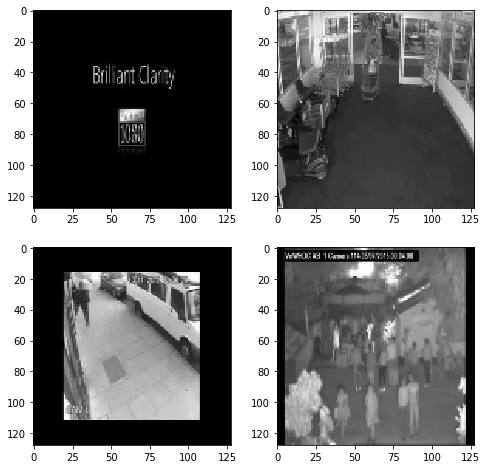

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(training_data_X2[0][2].reshape(128,128),cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(training_data_X2[11][129].reshape(128,128),cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(training_data_X2[8][140].reshape(128,128),cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(training_data_X2[9][25].reshape(128,128),cmap='gray')
plt.show()

### Training data preparation

In [10]:
X_train=training_data_X2

In [11]:
X_train.shape

(376, 300, 128, 128, 1)

In [12]:
y_train=np.array(M,dtype=np.int)

In [13]:
y_train.shape

(376,)

### Model with Conv3D

In [14]:
model = Sequential()

model.add(Conv3D(16, (3,3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model.add(Conv3D(32, (3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 298, 126, 126, 16) 448       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 298, 63, 63, 16)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 296, 61, 61, 32)   13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 296, 30, 30, 32)   0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8524800)           0         
_________________________________________________________________
dense_1 (Dense)      

### Train Models

In [16]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='best_model_weight.hdf5', save_best_only=True, verbose=1)

In [17]:
# Training the model for 40 epochs
model.fit(X_train, y_train, batch_size=4,epochs=10,validation_split=0.3, verbose=1, callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 263 samples, validate on 113 samples
Epoch 1/10
263/263 [==============================] - 4269s 16s/step - loss: 5.8201 - acc: 0.6388 - val_loss: 7.4172 - val_acc: 0.5398

Epoch 00001: val_loss improved from inf to 7.41718, saving model to best_model_weight.hdf5
Epoch 2/10
263/263 [==============================] - 4244s 16s/step - loss: 5.6383 - acc: 0.6502 - val_loss: 7.4172 - val_acc: 0.5398

Epoch 00002: val_loss did not improve from 7.41718
Epoch 3/10
263/263 [==============================] - 4244s 16s/step - loss: 5.6383 - acc: 0.6502 - val_loss: 7.4172 - val_acc: 0.5398

Epoch 00003: val_loss did not improve from 7.41718
Epoch 4/10
263/263 [==============================] - 4244s 16s/step - loss: 5.6383 - acc: 0.6502 - val_loss: 7.4172 - val_acc: 0.5398

Epoch 00004: val_loss did not improve from 7.41718
Epoch 5/10
263/263 [==============================] - 4160s 16s/step - loss: 5.6383 - acc: 0.6502 - val_loss: 7.4172 -

In [ ]:
model.save('3D_model.h5')